# IPYNB file specialized for YouTube comment analysis. Please use it freely.
# YouTubeのコメント解析に特化したIPYNBファイルです。ご自由にお使い下さい。

In [1]:
import requests
import json
import pandas as pd
from   sklearn.feature_extraction.text import TfidfVectorizer

# Get YouTube comments!!(YouTubeのコメントを取得します)
https://qiita.com/chieeeeno/items/ba0d2fb0a45db786746f

In [2]:
URL = 'https://www.googleapis.com/youtube/v3/'
API_KEY = 'Get the API yourself!!!!!'

In [3]:
def print_video_comment(video_id, n=10):
    comment = pd.DataFrame()
    params = {
        'key': API_KEY,
        'part': 'snippet',
        'videoId': video_id,
        'order': 'relevance',
        'textFormat': 'plaintext',
        'maxResults': n,
    }
    response = requests.get(URL + 'commentThreads', params=params)
    resource = response.json()
    for comment_info in resource['items']:
        # COMMENTS
        text = comment_info['snippet']['topLevelComment']['snippet']['textDisplay']
        # Number of GOODS
        like_cnt = comment_info['snippet']['topLevelComment']['snippet']['likeCount']
        # Number of reply
        reply_cnt = comment_info['snippet']['totalReplyCount']
        temp = pd.DataFrame([[text,like_cnt,reply_cnt]])
        comment = comment.append(temp) 
    return comment

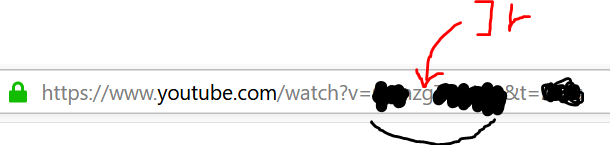

In [34]:
video_id = 'choose! URL'
#                                       ↓As a result of the experiment, Max is 100. 101 is impossible.
AIUEO = print_video_comment(video_id, n=100) 

# Save and load the acquired data(取得したデータを保存⇒読み込みする)

In [8]:
import openpyxl

In [35]:
##                  ↓Create current directory。
AIUEO.to_excel('AIUEO.xlsx', index=False)

# Create data for text mining(テキストマイニング用データ作成)

In [36]:
#Just line up the excel created in the previous step.
AIUEO = pd.read_excel('AIUEO.xlsx')

In [37]:
#Make a dictionary honestly
dataset = {
    'AIUEO': AIUEO,#........etc
           }

STR_DB = {}
for what in dataset.keys():
    temp_str = ""
    for i in range(len(dataset[what][0])): 
        temp_str = temp_str + dataset[what][0][i] + "。"
    STR_DB[what] = temp_str 

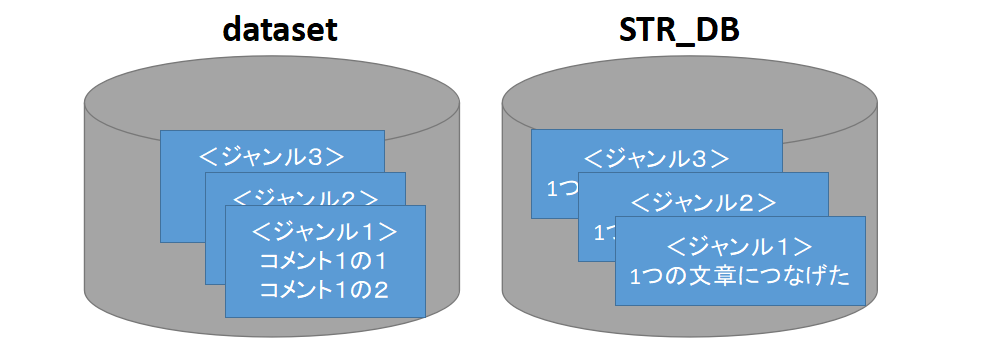

# Start textmining(テキストマイニング開始。)

In [38]:
#★★ Janome 'Hello 蛇の目'★★
from janome.tokenizer import Tokenizer
from janome.analyzer import Analyzer
from janome.tokenfilter import *

In [39]:
from pathlib import Path
import itertools
import collections
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
#Test if it was done(疎通テスト)。
t = Tokenizer()
s = STR_DB['darkness']
for token in t.tokenize(s):
     pass

# Count the words(コメントに登場した”単語”の数を数えてみる。)

In [40]:
#NOUN(名詞表)
writer = pd.ExcelWriter('名詞表.xlsx')
for what in dataset.keys():
    ana = Analyzer(token_filters=[POSKeepFilter(['名詞,一般']), TokenCountFilter(sorted=True,att='base_form')])
    m_count = list(ana.analyze(STR_DB[what]))
    df = pd.DataFrame(m_count, columns=['単語', '頻度'])
    #エクセルに記入　　　↓Name of the Sheetシート名。
    df.to_excel(writer, what)
writer.save()

In [41]:
#VERD(動詞表)
writer = pd.ExcelWriter('動詞表.xlsx')
for what in dataset.keys():
    ana = Analyzer(token_filters=[POSKeepFilter(['動詞,自立']), TokenCountFilter(sorted=True,att='base_form')])
    d_count = list(ana.analyze(STR_DB[what]))
    df = pd.DataFrame(d_count, columns=['単語', '頻度'])
    #エクセルに記入　　　↓Name of the Sheet(シート名)。
    df.to_excel(writer, what)
writer.save()

In [42]:
#ABJECTIVE(形容詞)
writer = pd.ExcelWriter('形容詞表.xlsx')
for what in dataset.keys():
    ana = Analyzer(token_filters=[POSKeepFilter(['形容詞,自立']), TokenCountFilter(sorted=True,att='base_form')])
    k_count = list(ana.analyze(STR_DB[what]))
    df = pd.DataFrame(k_count, columns=['単語', '頻度'])
    #エクセルに記入　　　↓Name of the Sheetシート名。
    df.to_excel(writer, what)
writer.save()

# Visualize with word cloud!(word cloudで可視化しよう！)

In [60]:
tan_list_bun_blank = [] #store words with blanks(パックごとの出現単語をブランクで開けて格納する。(分かち書き))
t = Tokenizer()
for what in STR_DB.keys():
    temp_tan_list = []
    all_kome      = STR_DB[what]  #each comments(コメントは１纏めにしてる。)
    temp_tan_list = [token.base_form for token in t.tokenize(all_kome)
             if token.part_of_speech.startswith('名詞,一般')
#             or token.part_of_speech.startswith('名詞,一般')
#             or token.part_of_speech.startswith('形容詞')
##            Specify as many as you like(orを使って好きなだけ指定する！)
                    ]
    temp_str = ""
    for word in temp_tan_list:
        temp_str = temp_str + word + " "
    tan_list_bun_blank.append(temp_str)    

### fpath = r"C:\Windows\Fonts\HGRGE.ttc" は、ttcファイルのある場所。
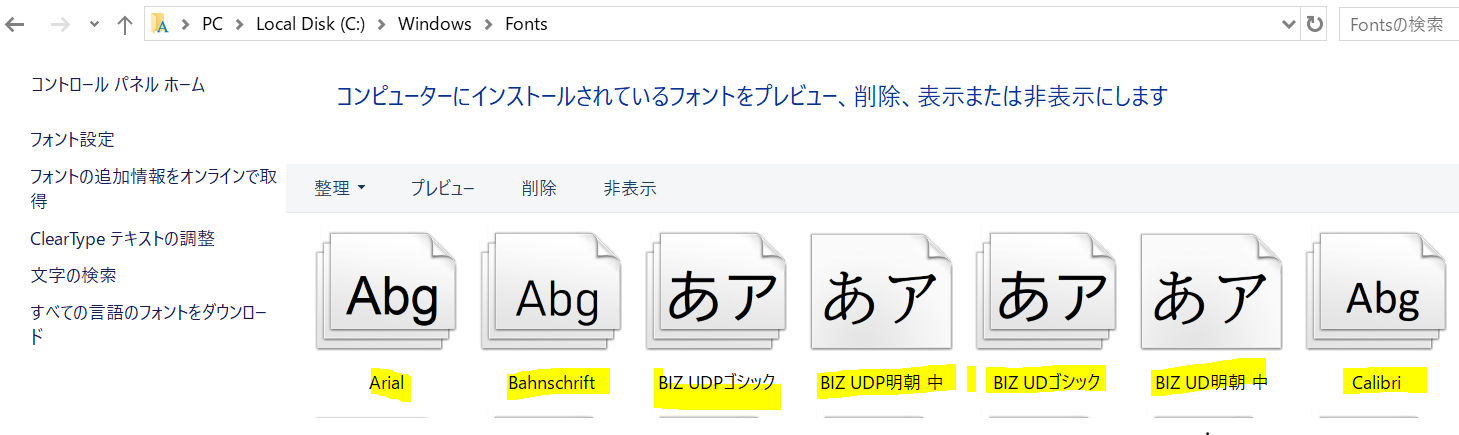

In [ ]:
#word cloud
from wordcloud import WordCloud
####                    　↓any ｔｔｃFILE(ttcファイルなら何でもＯＫ)
fpath = r"C:\Windows\Fonts\BIZ-UDGothicR.ttc"
wordcloud = WordCloud(background_color="white",font_path=fpath, width=900, height=500).generate(tan_list_bun_blank[4])

plt.figure(figsize=(15,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# TF-IDFを元に、２次元に描写してみよう。

In [62]:
tan_list_bun_blank = [] #1ジャンルごとの出現単語をブランクで開けて格納する。
t = Tokenizer()
for what in STR_DB.keys():
    temp_tan_list = []
    all_kome      = STR_DB[what]  #1ジャンルごとのコメント。コメントは１纏めにしてる。
    temp_tan_list = [token.base_form for token in t.tokenize(all_kome)
             if token.part_of_speech.startswith('動詞')
             or token.part_of_speech.startswith('名詞,一般')
             or token.part_of_speech.startswith('形容詞')
                    ]
    temp_str = ""
    for word in temp_tan_list:
        temp_str = temp_str + word + " "
    tan_list_bun_blank.append(temp_str)    

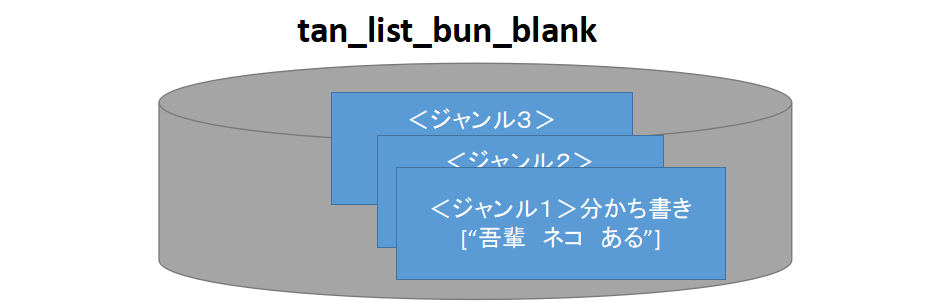

In [140]:
vectorizer = TfidfVectorizer()
X_onehot=vectorizer.fit_transform(tan_list_bun_blank)
X_onehot=X_onehot.toarray()

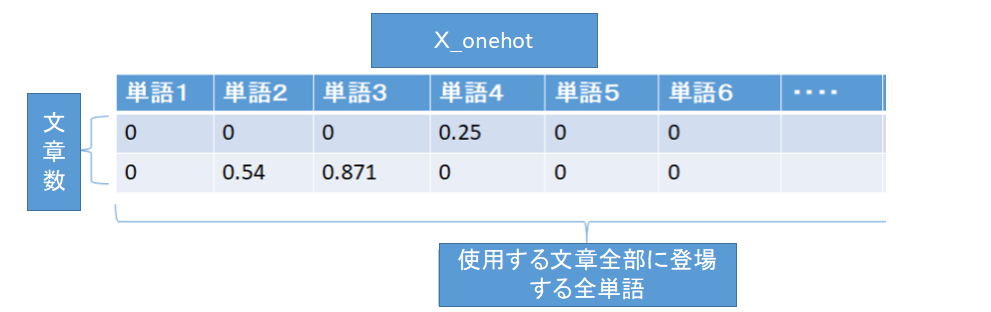

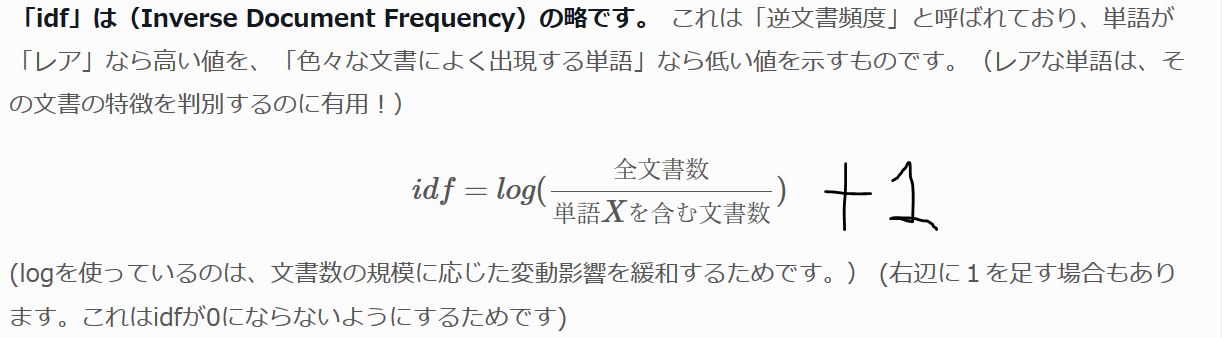
https://dev.classmethod.jp/machine-learning/yoshim_2017ad_tfidf_1-2/

In [ ]:
#重要度の”低い”単語を確認しよう！
#どのパックにも出ている単語「idf=log(文書数(パック数)/文書数(パック数))＋１」
idf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
df_idf = pd.DataFrame(columns=['idf']).from_dict(
                    dict(idf), orient='index')
df_idf.columns = ['idf']
display(df_idf.sort_values("idf").head(20).T)

In [65]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

#t-SNE
tsne= TSNE(n_components=2, verbose=1, n_iter=500)
tsne_tfidf = tsne.fit_transform(X_onehot)

#DataFrameに格納
df_tsne = pd.DataFrame(tsne.embedding_[:, 0],columns = ["x"])
df_tsne["y"] = pd.DataFrame(tsne.embedding_[:, 1])

[t-SNE] Computing 8 nearest neighbors...
[t-SNE] Indexed 9 samples in 0.000s...
[t-SNE] Computed neighbors for 9 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 9 / 9
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.420128
[t-SNE] KL divergence after 500 iterations: 0.229799


In [66]:
df_tsne

,x,y
0,148.439407,414.647980
1,-376.188477,39.437183
2,-81.334450,215.135193
3,8.315066,-385.799683
4,-297.867554,-259.858490
5,-25.123035,-62.653755
6,-346.249207,370.777527
7,283.421051,-197.608154
8,275.490906,115.180542


In [ ]:
#↓文書数に合わせて、愚直に定義。
col = ["r","g","b","c","m","y","k","w","r"]
#↓datasetに合わせて下さい
pack = ['AIUEO',#....etc
       ]
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(121)
ax.scatter(df_tsne.iloc[:,0],df_tsne.iloc[:,1],color=col ,s=40)
ax.set_title('Pack PCA')

for i, t in enumerate(pack):
    msg = str(t)
    plt.annotate(msg, (df_tsne.iloc[i,0], df_tsne.iloc[i,1]))  # x,y need brackets

# BoW(変数X-onehot)の圧縮＝＞k-means

In [68]:
#t-SNE(onehotベクトルはスパース過ぎる！なので、次元削減しよう。)
#                     　↓次元数を決める。
tsne3= TSNE(n_components=3, verbose=1, n_iter=500)
tsne_tfidf3 = tsne3.fit_transform(X_onehot)

#DataFrameに格納
df_tsne3 = pd.DataFrame(tsne.embedding_[:, 0],columns = ["x"])
df_tsne3["y"] = pd.DataFrame(tsne3.embedding_[:, 1])
df_tsne3["z"] = pd.DataFrame(tsne3.embedding_[:, 2])

[t-SNE] Computing 8 nearest neighbors...
[t-SNE] Indexed 9 samples in 0.000s...
[t-SNE] Computed neighbors for 9 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 9 / 9
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 94.092674
[t-SNE] KL divergence after 500 iterations: 1.642186


In [69]:
df_tsne3

,x,y,z
0,148.439407,-20.176443,169.885406
1,-376.188477,64.317657,1013.211060
2,-81.334450,1085.691650,-681.407410
3,8.315066,-164.987183,-702.389160
4,-297.867554,-60.279816,-76.183189
5,-25.123035,97.798225,193.036957
6,-346.249207,218.868561,85.638550
7,283.421051,213.335983,-108.171379
8,275.490906,-1449.643066,431.527405


In [70]:
from sklearn.cluster import KMeans
pred2 = KMeans(n_clusters=2).fit_predict(df_tsne3)
pred3 = KMeans(n_clusters=3).fit_predict(df_tsne3)
pred4 = KMeans(n_clusters=4).fit_predict(df_tsne3)

In [71]:
#次元削減後データ⇒ｋ－meansで分類します。
print(pred2)
print(pred3)
print(pred4)

[0 0 0 0 0 0 0 0 1]
[0 0 2 0 0 0 0 0 1]
[1 0 3 1 1 1 1 1 2]


# 全文章の単語／１単語。ごとで、IDFを求める（重要順に）

In [72]:
#小さすぎるTFIDFは、無視。
##           ↓任意。
MIN_TFIDF = 0.25
def is_bigger_than_min_tfidf(term, terms, tfidfs):
    '''
    [term for term in terms if is_bigger_than_min_tfidf(term, terms, tfidfs)]で使う
    list化した、語たちのtfidfの値のなかから、順番に当てる関数。
    tfidfの値がMIN_TFIDFよりも大きければTrueを返す
    '''
    if tfidfs[terms.index(term)] > MIN_TFIDF:
        return True
    return False

In [ ]:
terms = vectorizer.get_feature_names()
for i in range(9):
    #            ↓iの「tf-idf値 in BoW」
        tfidfs = X_onehot[i]
        print([term for term in terms if is_bigger_than_min_tfidf(term, terms, tfidfs)])

# 今度は、１ジャンル（＝１文章）/１単語。ごとで、IDFを求める（重要順に）

In [76]:
#ジャンル（文章）ごとの形態素解析を定義
tan_list_bunS = [] #ジャンル（文章）ごとの出現単語を登場させる。
t = Tokenizer()
for what in STR_DB.keys():
    temp_tan_list_bun = []
    all_kome      = STR_DB[what]  #ジャンル（文章）ごとにコメントが出てくる！コメントは１纏めにしてる。
    temp_tan_list_bun = [token.base_form for token in t.tokenize(all_kome)
             if token.part_of_speech.startswith('動詞')
             or token.part_of_speech.startswith('名詞,一般')
             or token.part_of_speech.startswith('形容詞')
                    ]
    tan_list_bunS.append(temp_tan_list_bun)    

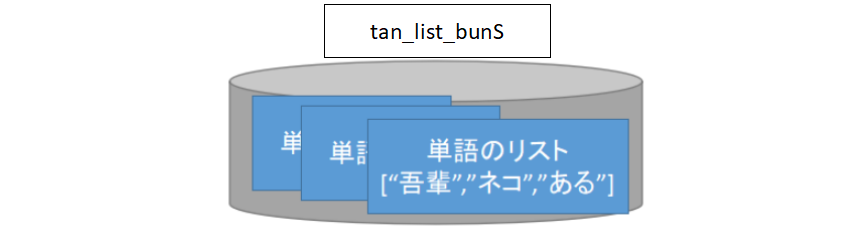

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
tf_idf_list = []
for index in range(len(tan_list_bun_blank)):
    vectorizer = TfidfVectorizer()
    temp_tfidf = vectorizer.fit_transform(tan_list_bunS[index])
    tf_idf_list.append([vectorizer, temp_tfidf.toarray()])

In [ ]:
for index in range(len(tf_idf_list)):
    idf = dict(zip(tf_idf_list[index][0].get_feature_names(), tf_idf_list[index][0].idf_))
    df_idf = pd.DataFrame(columns=['idf']).from_dict(
                        dict(idf), orient='index')
    df_idf.columns = ['idf']
    display(df_idf.sort_values("idf",ascending=False).head(10).T) 

# 共起語を見つける

In [80]:
import collections
#まずは、準備から！！
##条件付き分かち書き＆基本形に変換する。（１文ごとに形態素解析。そして、リスト化！）
###文をまたいで、連携してたらおかしい。
writer2 = pd.ExcelWriter('バイグラムズ.xlsx')
writer3 = pd.ExcelWriter('トリグラムズ.xlsx')
t = Tokenizer()

for what in dataset.keys():
    tan_listS =[]
    for line  in dataset[what][:][0]:
        tan_list = [token.base_form for token in t.tokenize(line)
              if token.part_of_speech.startswith('動詞')
              or token.part_of_speech.startswith('名詞,一般')
              or token.part_of_speech.startswith('形容詞')
                   ]
        tan_listS.append(tan_list)
        
###バイグラム。##################################################################################
    result_2 = []
    for one_set in tan_listS:
        temp_set = []
        for it, c in enumerate(one_set):
            if it + 2 > len(one_set):
                break
            temp_set.append( (one_set[it] , one_set[it+1]) )
        result_2 = result_2 + temp_set
    col_2 = collections.Counter(result_2)
    col_2 = sorted(col_2.items(),key=lambda x:x[1],reverse=True)
    df = pd.DataFrame(col_2, columns=['組1','頻度'])
    df.to_excel(writer2, what)     
        
###トリグラム。#################################################################################
    result_3 = []
    for one_set in tan_listS:
        temp_set = []
        for it, c in enumerate(one_set):
            if it + 2 > len(one_set):
                break
            temp_set.append( (one_set[it] , one_set[it+1]) )
                    ###更にもう１個となりを”チラ見”。あれば、要素に加える。
            if it + 3 > len(one_set):
                pass
            else:
                temp_set.append( (one_set[it] , one_set[it+2]) ) 
        result_3 = result_3 + temp_set
    col_3 = collections.Counter(result_3)
    col_3 = sorted(col_3.items(),key=lambda x:x[1],reverse=True)
    df = pd.DataFrame(col_3, columns=['組1','頻度'])
    df.to_excel(writer3, what)     
writer2.save()
writer3.save()

# doc2vec（ジャンル（文章）ごとに文章をベクトル化する。）
# word2vecにも対応！
https://qiita.com/naotaka1128/items/2c4551abfd40e43b0146#2-gensim-%E3%81%A7-doc2vec-%E3%81%AE%E3%83%A2%E3%83%87%E3%83%AB%E6%A7%8B%E7%AF%89

In [81]:
#クラスごとにラベルを構築
cls_list_bunS = []
for what in STR_DB.keys():
    cls_list_bunS.append(what)

In [83]:
#クラスごとの形態素解析を定義
tan_list_bunS = [] #パックごとの出現単語を登場させる。
t = Tokenizer()
for what in STR_DB.keys():
    temp_tan_list_bun = []
    all_kome      = STR_DB[what]  #パックごとにコメントが出てくる！コメントは１纏めにしてる。
    temp_tan_list_bun = [token.base_form for token in t.tokenize(all_kome)
             if token.part_of_speech.startswith('動詞')
             or token.part_of_speech.startswith('名詞,一般')
             or token.part_of_speech.startswith('形容詞')
                    ]
    tan_list_bunS.append(temp_tan_list_bun)    

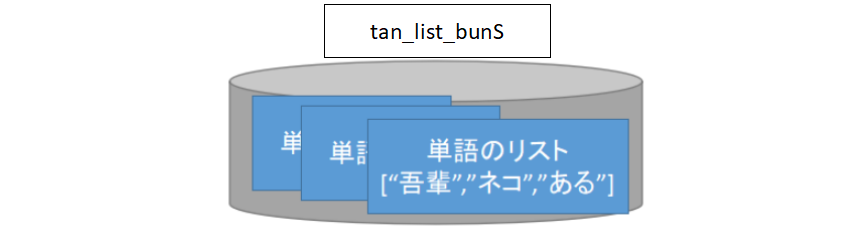

In [84]:
#解析用データ作成ツール！
# 参考記事： http://qiita.com/okappy/items/32a7ba7eddf8203c9fa1
class LabeledListSentence(object):
    def __init__(self, words_list, labels):
        self.words_list = words_list
        self.labels = labels

    def __iter__(self):
        for i, words in enumerate(self.words_list):
            yield models.doc2vec.LabeledSentence(words, ['%s' % self.labels[i]])

In [87]:
# ライブラリ読み込み
from gensim import models

# gensim にコメントを登録
# コメントにパック名を付与するため、拡張クラスを使っています。
sentences = LabeledListSentence(tan_list_bunS, cls_list_bunS)
# doc2vec の学習条件設定
# alpha: 学習率 / min_count: X回未満しか出てこない単語は無視
# size: ベクトルの次元数 / iter: 反復回数 / workers: 並列実行数
model = models.Doc2Vec(alpha=0.25, min_count=2,
                       size=5, iter=20,works=13)

# doc2vec の学習前準備(単語リスト構築)
model.build_vocab(sentences)

# Wikipedia から学習させた単語ベクトルを無理やり適用して利用することも出来ます
# model.intersect_word2vec_format('./data/wiki/wiki2vec.bin', binary=True)

#doc2vecのアップデートにより、『total_examples』,『epochs』は、必須の引数になりました。
# 学習実行             ↓いる！(無いとエラー)　　　　　　　　↓いる！（無いとエラー）　　　　　　　　　　　　　　
model.train(sentences, total_examples = model.corpus_count, epochs = model.epochs)

# セーブ
#model.save('./data/doc2vec.model')

# 学習後はモデルをファイルからロード可能
# model = models.Doc2Vec.load('./data/doc2vec.model')

# 順番が変わってしまうことがあるのでリストは学習後に再呼び出し
companies = model.docvecs.offset2doctag

C:\Users\araik\Anaconda3\lib\site-packages\gensim\models\doc2vec.py:570: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")
C:\Users\araik\Anaconda3\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
C:\Users\araik\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  # Remove the CWD from sys.path while we load stuff.


### doc2vecだけど、word2vecも出来る

In [ ]:
# model.most_similar(positive=[単語]) で似ている単語が出せる
##word2vecの上位互換がdoc2vec？
model.most_similar(positive=['地元'])

In [ ]:
#単語の足し算引き算。
model.most_similar(positive=['地元'], negative=['する'])

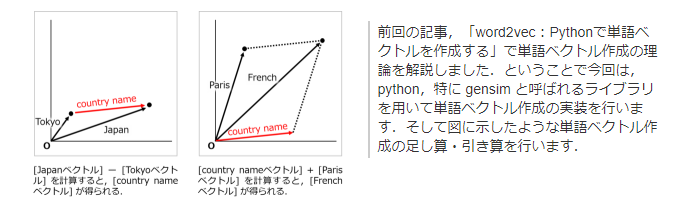

### doc2vecです↓

In [1]:
# model.docvecs.most_similar(positive=[ジャンルのID])
model.docvecs.most_similar(positive=[8])

# LDA

In [127]:
#クラスごとの形態素解析を定義
tan_list_bunS = [] #パックごとの出現単語を登場させる。
t = Tokenizer()
for what in STR_DB.keys():
    temp_tan_list_bun = []
    all_kome      = STR_DB[what]  #パックごとにコメントが出てくる！コメントは１纏めにしてる。
    temp_tan_list_bun = [token.base_form for token in t.tokenize(all_kome)
             if token.part_of_speech.startswith('名詞,一般')
#            or token.part_of_speech.startswith('動詞,一般')
#            or token.part_of_speech.startswith('形容詞')
                    ]
    tan_list_bunS.append(temp_tan_list_bun)    

In [112]:
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from collections import defaultdict
from pathlib import Path
import itertools
import os

In [128]:
dictionary = Dictionary(tan_list_bunS)
corpus = [dictionary.doc2bow(text) for text in tan_list_bunS]

In [ ]:
#           ↓お好きにどうぞ。
NUM_TOPICS = 9
#------------LDAを実施する！---------------------------------------------------#
lda = LdaModel(corpus     = corpus, 
               num_topics = NUM_TOPICS, 
               id2word    = dictionary)

for i in range(NUM_TOPICS):
    print('tpc_{0}: {1}'.format(i, lda.print_topic(i)[0:80]+'...'))

# ベイズの定理でテキスト分類！

In [107]:
#ソース：https://github.com/kujirahand/book-python\scraping.git「pythonによるスクレイピング＆機械学習」
import math, sys
from janome.tokenizer import Tokenizer # 形態素解析用

class BayesianFilter:
    """ ベイジアンフィルタ """
    def __init__(self):
        self.words = set() # 出現した単語を全て記録
        self.word_dict = {} # カテゴリごとの単語出現回数を記録
        self.category_dict = {} # カテゴリの出現回数を記録

    # 形態素解析を行う
    def split(self, text):
        result = []
        t = Tokenizer()
        malist = t.tokenize(text)
        for w in malist:
            sf = w.surface   # 区切られた単語そのまま 
            bf = w.base_form # 単語の基本形
            if bf == '' or bf == "*": bf = sf
            result.append(bf)
        return result

    # 単語とカテゴリを数える処理 
    def inc_word(self, word, category):
        # 単語をカテゴリに追加
        if not category in self.word_dict:
            self.word_dict[category] = {}
        if not word in self.word_dict[category]:
            self.word_dict[category][word] = 0
        self.word_dict[category][word] += 1
        self.words.add(word)
    def inc_category(self, category):
        # カテゴリを加算する
        if not category in self.category_dict:
            self.category_dict[category] = 0
        self.category_dict[category] += 1

    # テキストを学習する 
    def fit(self, text, category):
        """ テキストの学習 """
        word_list = self.split(text)
        for word in word_list:
            self.inc_word(word, category)
        self.inc_category(category)

    # カテゴリにおける単語リストのスコアを計算する 
    def score(self, words, category):
        score = math.log(self.category_prob(category))
        for word in words:
            score += math.log(self.word_prob(word, category))
        return score

    # テキストのカテゴリ分けを行う
    def predict(self, text):
        best_category = None
        max_score = -sys.maxsize 
        words = self.split(text)
        score_list = []
        for category in self.category_dict.keys():
            score = self.score(words, category)
            score_list.append((category, score))
            if score > max_score:
                max_score = score
                best_category = category
        return best_category, score_list

    # カテゴリ内の単語出現数を得る
    def get_word_count(self, word, category):
        if word in self.word_dict[category]:
            return self.word_dict[category][word]
        else:
            return 0

    # カテゴリ/総カテゴリを計算
    def category_prob(self, category):
        sum_categories = sum(self.category_dict.values())
        category_v = self.category_dict[category]
        return category_v / sum_categories
        
    # カテゴリ内の単語の出現率を計算 
    def word_prob(self, word, category):
        n = self.get_word_count(word, category) + 1
        d = sum(self.word_dict[category].values()) + len(self.words)
        return n / d

In [108]:
bf = BayesianFilter()

for what in dataset:
    for one_bun in dataset[what][:][0]:
        bf.fit(one_bun,what)

In [2]:
#任意の文章が、どれと近いは判別する。（ベイジアンフィルタで）
#　　　　　　　　　　　　　　　↓文章を適当に入力。
pre, scorelist = bf.predict("上手いですね")
print("結果=",pre)
print(scorelist)